In [2]:
import numpy as np
from datetime import datetime
from thesaurus import Word
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle

Reading the dataset to obtain tweets from the time period

In [3]:
def get_tweets(path="datasets/training_set_tweets.txt"):
    with open(path, encoding="utf8") as f:
        lines = f.readlines()
        
        tweets = []
        dates  = []

        split = lambda t: t.split('\t')
        
        for line in map(split, lines):
            if len(line) < 4 or len(line[3]) <= 10:
                continue
            try:
                dates.append(datetime.strptime(line[3][:10], "%Y-%m-%d"))
                tweets.append(line[2])
            except ValueError:
                continue
            
        
    return tweets, dates

In [4]:
tweets, dates = get_tweets()
len(tweets)

3675242

Now let's write the sentiment analysis algo.

In [4]:
#Remember this takes ~1-2 min to run
def get_poms_synonyms():
    with open("poms.txt") as f:
        words = f.read().split(',')
        
        synonyms = {}
        for word in words:
            synonyms[word] = Word(word).synonyms()
            
    return synonyms

In [6]:
poms_synonyms = get_poms_synonyms()

In [7]:
def poms_scores(text, poms_synonyms):
    raw_scores = defaultdict(int)
    tokens = text.lower().split(' ')
    
    for token in tokens:
        for word in poms_synonyms:
            if token == word or token in poms_synonyms[word]:
                raw_scores[word] += 1
    
    scores = {}
    
    scores['tension'] = raw_scores['tense']         + \
                        raw_scores['shaky']         + \
                        raw_scores['on edge']       + \
                        raw_scores['panicky']       + \
                       -raw_scores['relaxed']       + \
                        raw_scores['uneasy']        + \
                        raw_scores['restless']      + \
                        raw_scores['nervous']       + \
                        raw_scores['anxious']
    
    scores['depression'] = raw_scores['unhappy']    + \
                        raw_scores['sorry']         + \
                        raw_scores['sad']           + \
                        raw_scores['blue']          + \
                        raw_scores['hopeless']      + \
                        raw_scores['unworthy']      + \
                        raw_scores['discouraged']   + \
                        raw_scores['lonely']        + \
                        raw_scores['helpless']      + \
                        raw_scores['worthless']     + \
                        raw_scores['terrified']     + \
                        raw_scores['guilty']        
    
    scores['anger'] =   raw_scores['angry']         + \
                        raw_scores['peeved']        + \
                        raw_scores['grouchy']       + \
                        raw_scores['spiteful']      + \
                        raw_scores['annoyed']       + \
                        raw_scores['resentful']     + \
                        raw_scores['bitter']        + \
                        raw_scores['ready to fight']+ \
                        raw_scores['rebellious']    + \
                        raw_scores['deceived']      + \
                        raw_scores['furious']       + \
                        raw_scores['bad tempered']  
    
    scores['fatigue'] = raw_scores['worn out']      + \
                        raw_scores['listless']      + \
                        raw_scores['fatigued']      + \
                        raw_scores['exhausted']     + \
                        raw_scores['sluggish']      + \
                        raw_scores['weary']         + \
                        raw_scores['bushed']
    
    scores['confusion'] = raw_scores['confused']     + \
                        raw_scores['distracted']     + \
                        raw_scores['muddled']        + \
                        raw_scores['bewildered']     + \
                       -raw_scores['efficient']      + \
                        raw_scores['forgetful']      + \
                        raw_scores['uncertain']
    
    scores['vigour'] =  raw_scores['lively']         + \
                        raw_scores['active']         + \
                        raw_scores['energetic']      + \
                        raw_scores['cheerful']       + \
                        raw_scores['alert']          + \
                        raw_scores['peppy']          + \
                        raw_scores['carefree']       + \
                        raw_scores['vigorous']

    
    return scores
        

Example tweet (demonstrated emotion):

In [8]:
tweets[9]

'...including his last failed relationship.  and while I know that none of it is grounded in reality, and I actually am worried about him...'

In [9]:
poms_scores(tweets[9], poms_synonyms)

{'tension': 5,
 'depression': 0,
 'anger': 0,
 'fatigue': 0,
 'confusion': 0,
 'vigour': 0}

Finally, we need to sort the Twitter dataset by day and plug each tweet into the POMS machine to get time series. Most of these functions will operate on millions of tweets so they'll probably take some time.

In particular, the function below will take approximately 1 minute per 100,000 tweets processed.

In [35]:
def sentiment_time_dict(tweets, dates, poms_synonyms):
    sent_dict = defaultdict(lambda: {'tension': 0,
                                     'depression': 0,
                                     'anger': 0,
                                     'fatigue': 0,
                                     'confusion': 0,
                                     'vigour': 0,
                                     'total': 0})
    start_date = datetime(2009, 9, 1)
    discarded = 0.0
    counter = 0
    
    for tweet, date in zip(tweets, dates):
        counter += 1
        if counter % 100000 == 0:
            print("%d tweets processed." % counter)
        
        scores = poms_scores(tweet, poms_synonyms)
        
        days = (date - start_date).days
        if days < 0:
            discarded += 1
            continue
        
        sent_dict[days]['tension'] += scores['tension']
        sent_dict[days]['depression'] += scores['depression']
        sent_dict[days]['anger'] += scores['anger']
        sent_dict[days]['fatigue'] += scores['fatigue']
        sent_dict[days]['confusion'] += scores['confusion']
        sent_dict[days]['vigour'] += scores['vigour']
        sent_dict[days]['total'] += 1
        
    for date in sent_dict:
        sent_dict[date]['tension'] /= sent_dict[date]['total']
        sent_dict[date]['depression'] /= sent_dict[date]['total']
        sent_dict[date]['anger'] /= sent_dict[date]['total']
        sent_dict[date]['fatigue'] /= sent_dict[date]['total']
        sent_dict[date]['confusion'] /= sent_dict[date]['total']
        sent_dict[date]['vigour'] /= sent_dict[date]['total']
        
    print("Dictionary construction complete. %f percent of tweets discarded." % (100 * discarded / len(tweets)) )
    return dict(sent_dict)

In [2]:
def load_sent_dict(path="sent_dict.txt"):
    with open(path, "rb") as f:
        return pickle.load(f)

def save_sent_dict(sent_dict, path="sent_dict.txt"):
    with open(path, "wb") as f:
        pickle.dump(sent_dict, f, pickle.HIGHEST_PROTOCOL)

In [37]:
sent_dict = sentiment_time_dict(tweets, dates, poms_synonyms)

100000 tweets processed.
200000 tweets processed.
300000 tweets processed.
400000 tweets processed.
500000 tweets processed.
600000 tweets processed.
700000 tweets processed.
800000 tweets processed.
900000 tweets processed.
1000000 tweets processed.
1100000 tweets processed.
1200000 tweets processed.
1300000 tweets processed.
1400000 tweets processed.
1500000 tweets processed.
1600000 tweets processed.
1700000 tweets processed.
1800000 tweets processed.
1900000 tweets processed.
2000000 tweets processed.
2100000 tweets processed.
2200000 tweets processed.
2300000 tweets processed.
2400000 tweets processed.
2500000 tweets processed.
2600000 tweets processed.
2700000 tweets processed.
2800000 tweets processed.
2900000 tweets processed.
3000000 tweets processed.
3100000 tweets processed.
3200000 tweets processed.
3300000 tweets processed.
3400000 tweets processed.
3500000 tweets processed.
3600000 tweets processed.
Dictionary construction complete. 10.478412 percent of tweets discarded.


This cell should be used for saving and loading sent_dict as needed.

In [3]:
sent_dict = load_sent_dict()

In [4]:
def sentiment_time_series(sent_dict, key):
    N = max(sent_dict.keys())
    
    T = np.ndarray((N,))
    for i in range(N):
        T[i] = sent_dict[i][key]
        
    #convert to z-scores
    mean = np.mean(T)
    std  = np.std(T)
    T = (T - mean) / std
        
    return T

In [7]:
series = sentiment_time_series(sent_dict, 'vigour') - sentiment_time_series(sent_dict, 'depression')

We are finally able to view the results of our time series. Below is a happiness score around Thanksgiving, which occurs at $x=6$ on the graph.

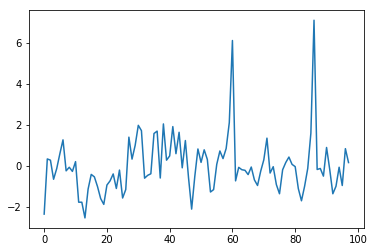

In [8]:
fig, ax = plt.subplots()
ax.plot(series)